In [3]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import os
import sys
from ipywidgets import widgets
from IPython.display import display, HTML
from IPython.display import clear_output
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import numpy as np


# Customized modules
HOME = '/home/serinatan/project/GPU-Virtualization-Benchmarks/util'
if HOME not in sys.path:
    sys.path.append(HOME)

import data.scripts.common.format as fmt
import data.scripts.common.constants as const
import data.scripts.common.help_iso as hi

from gpupool.workload import BatchJob
from gpupool.predict import Allocation, StageOne, StageTwo

SCRIPT_PATH = os.path.join(HOME, 'data/scripts') 
PKL_PATH = os.path.join(HOME, 'data/pickles') 
CSV_PATH = os.path.join(HOME, 'data/csv')
TIME_PATH = os.path.join(HOME, 'data/timeline')

%config InlineBackend.figure_format ='retina'
plt.style.use('seaborn-talk')

pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [4]:
batch = BatchJob(200, num_benchmarks_per_job=10, num_jobs=10)

BatchJob 0 synthesizes 10 jobs.


In [9]:
# batch.calculate_gpupool_performance(Allocation.One_D, StageOne.GPUSim, StageTwo.Full, at_least_once=True)
batch._calculate_gpupool_performance(Allocation.Three_D, StageOne.GPUSim, StageTwo.Full, at_least_once=False)
# batch.calculate_gpupool_performance(Allocation.Three_D, StageOne.GPUSim, StageTwo.Weighted, at_least_once=False)
# batch.calculate_gpupool_performance(Allocation.Three_D, StageOne.GPUSim, StageTwo.Steady, at_least_once=False)

# perf = batch.df_pair[batch.df_pair['pair_str'] == 'job-4+job-9'].iloc[0]['pair_job'].get_performance(Allocation.Three_D, StageOne.GPUSim, StageTwo.Full, 4, at_least_once=False)
# perf['One_D-GPUSim-Full-False-perf'].visualize("we", width=1500).display()
# perf['Three_D-GPUSim-Full-False-perf'].weighted_speedup()

Getting performance for ['job-0', 'job-1']
Getting performance for ['job-0', 'job-2']
Getting performance for ['job-0', 'job-3']
Getting performance for ['job-0', 'job-4']
Getting performance for ['job-0', 'job-5']
Getting performance for ['job-0', 'job-6']
Getting performance for ['job-0', 'job-7']
Getting performance for ['job-0', 'job-8']
Getting performance for ['job-0', 'job-9']
Getting performance for ['job-1', 'job-2']
Getting performance for ['job-1', 'job-3']
Getting performance for ['job-1', 'job-4']
Getting performance for ['job-1', 'job-5']
Getting performance for ['job-1', 'job-6']
Getting performance for ['job-1', 'job-7']
Getting performance for ['job-1', 'job-8']
Getting performance for ['job-1', 'job-9']
Getting performance for ['job-2', 'job-3']
Getting performance for ['job-2', 'job-4']
Getting performance for ['job-2', 'job-5']
Getting performance for ['job-2', 'job-6']
Getting performance for ['job-2', 'job-7']
Getting performance for ['job-2', 'job-8']
Getting per

In [10]:
name_1d = "One_D-GPUSim-Full-False"
name_3d = "Three_D-GPUSim-Full-False"
name_3d_steady = "Three_D-GPUSim-Steady-False"
name_3d_weighted = "Three_D-GPUSim-Weighted-False"
batch.df_pair.columns

Index(['pair_job', 'pair_str', 'Three_D-GPUSim-Full-False-option', 'Three_D-GPUSim-Full-False-perf', 'Three_D-GPUSim-Full-False-ws'], dtype='object')

In [5]:
print("Number of possible pairs:", len(batch.df_pair.index))
print("Number of feasible 1D pairs:", len(batch.df_pair[~batch.df_pair[name_1d + '-option'].isnull()].index))
print("Number of feasible 3D pairs:", len(batch.df_pair[~batch.df_pair[name_3d + '-option'].isnull()].index))

Number of possible pairs: 105
Number of feasible 1D pairs: 35
Number of feasible 3D pairs: 105


In [26]:
pair_str_list = batch.df_pair['pair_str']


pair_str_dd = widgets.Dropdown(options=pair_str_list, description="Pair_str:")
button = widgets.Button(description='Draw', button_style='info')
timeline_out = widgets.Output()

width = 1000

def show(option, perf, title):
#     option.print_config()
    option.print_interference()
    perf.visualize(title, xmax=12e6).display()
    print('sld:', perf.sld)
    print('ws:', sum(perf.sld))


def onclick(b):
    timeline_out.clear_output()
    series = batch.df_pair[batch.df_pair['pair_str'] == pair_str_dd.value].iloc[0]

    with timeline_out:
        pair_job = series['pair_job']
        [print(job.name, job.benchmarks) for job in pair_job.jobs]

        print('1D allocation: ')
        if series[name_1d + '-option']:
            option = series[name_1d + '-option']
            perf = series[name_1d + '-perf']
            print('\n')
            print("ctx", option.ctx)
            print('\n')
            
            show(option, perf, "1D")
        else:
            print("None available.")
            
        print('3D allocation: ')
        if series[name_3d + '-option']:
            option = series[name_3d + '-option']
            perf = series[name_3d + '-perf']
            print('\n')
            
            show(option, perf, "3D")
        

button.on_click(onclick)
widgets.VBox([pair_str_dd, button, timeline_out])

{'pair_str': 'geomean', 'One_D-GPUSim-Full-True-ws': 1.4021601428737058, 'Three_D-GPUSim-Full-True-ws': 1.4707712690148897}


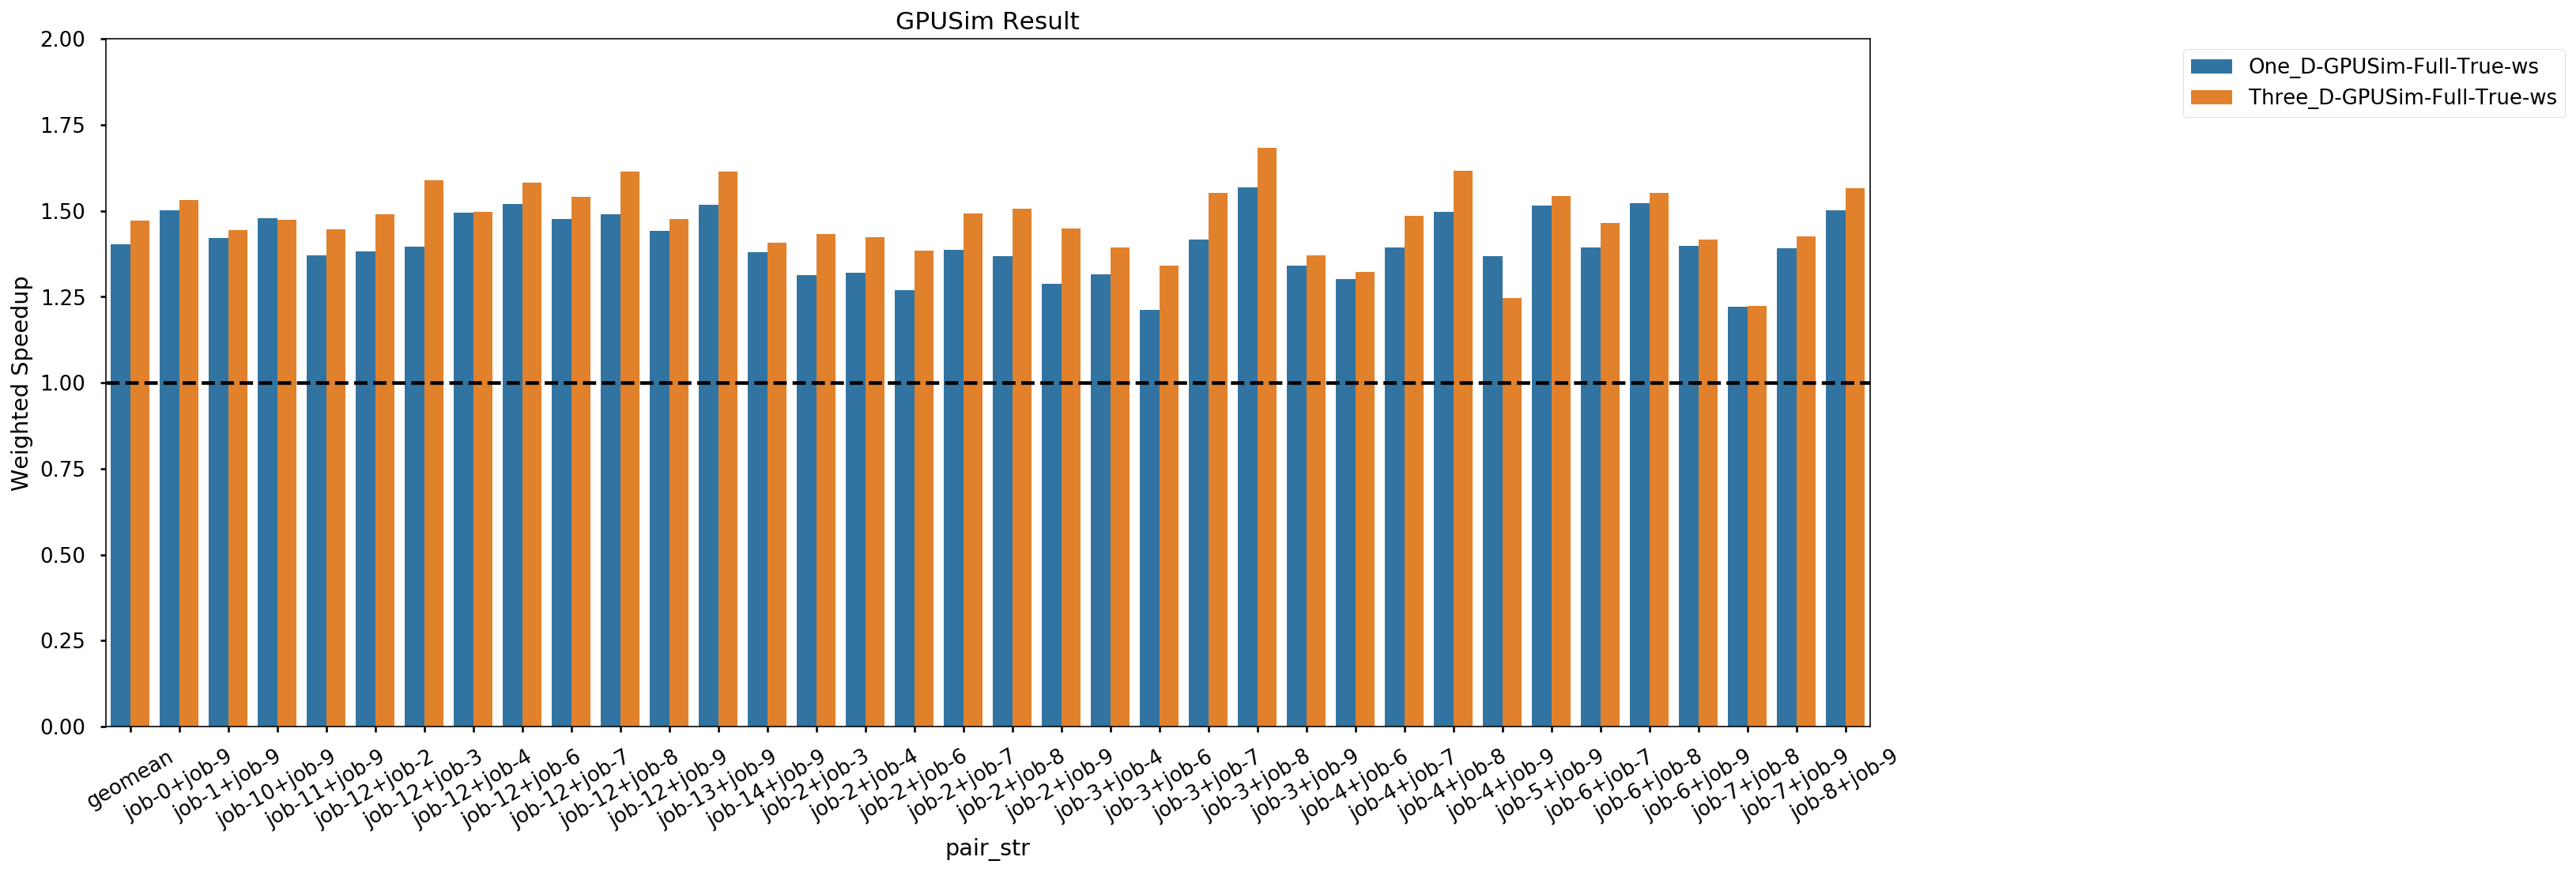

In [6]:
ws_1d = name_1d + '-ws'
ws_3d = name_3d + '-ws'
df_both = batch.df_pair[batch.df_pair[ws_1d] > 0]

geomean = {'pair_str': 'geomean', 
           ws_1d: scipy.stats.mstats.gmean(df_both[ws_1d]),
           ws_3d: scipy.stats.mstats.gmean(df_both[ws_3d]),
          }
print(geomean)

df_both = df_both.append(geomean, ignore_index=True)

df_both_long = pd.melt(df_both, id_vars=['pair_str'], 
                          value_vars=[ws_1d, ws_3d], 
                          var_name='Allocation Type').sort_values(['pair_str']).reset_index(drop=True)


plt.figure(figsize=(20,8))
ax = sns.barplot(x='pair_str', y='value', hue='Allocation Type', data=df_both_long, hue_order=[ws_1d, ws_3d,])
plt.xticks(rotation=30)
plt.ylabel('Weighted Speedup')
plt.ylim([0, 2])

ax.legend(bbox_to_anchor=(1.4, 1))
ax.axhline(1.0, ls='--', color="black")
plt.title('GPUSim Result')

plt.show()


# Interference matrix hit rate

In [20]:
batch.df_pair.columns

Index(['pair_job', 'pair_str', 'Three_D-GPUSim-Full-False-option', 'Three_D-GPUSim-Full-False-perf', 'Three_D-GPUSim-Full-False-ws', 'Three_D-GPUSim-Steady-False-option', 'Three_D-GPUSim-Steady-False-perf', 'Three_D-GPUSim-Steady-False-ws'], dtype='object')

In [11]:
hit_rate = batch.df_pair['Three_D-GPUSim-Full-False-option'].apply(lambda x: x.interference_hit_percentage())

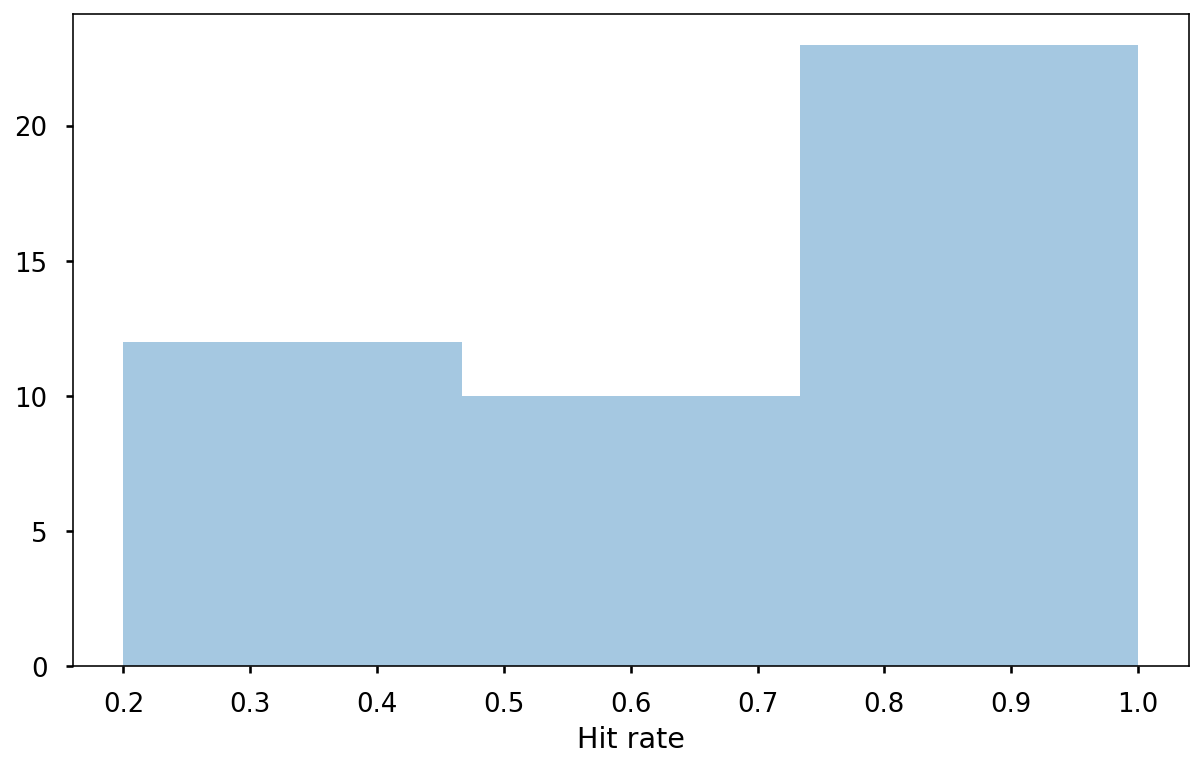

In [25]:
plt.figure(figsize=(10, 6))
sns.distplot(hit_rate, hist=True, rug=False, norm_hist=False, kde=False);
plt.xlabel("Hit rate")
# plt.title('ctx usage distribution')
plt.show()

# Steady state v.s. full calculation

geomean 3d full: 1.4592384181411555
geomean 3d steady: 1.465157251622529
geomean 3d weighted: 1.4915279225783271
Error of 3d steady: 0.004351558289986918
Error of 3d weighted: 0.03340406539651429


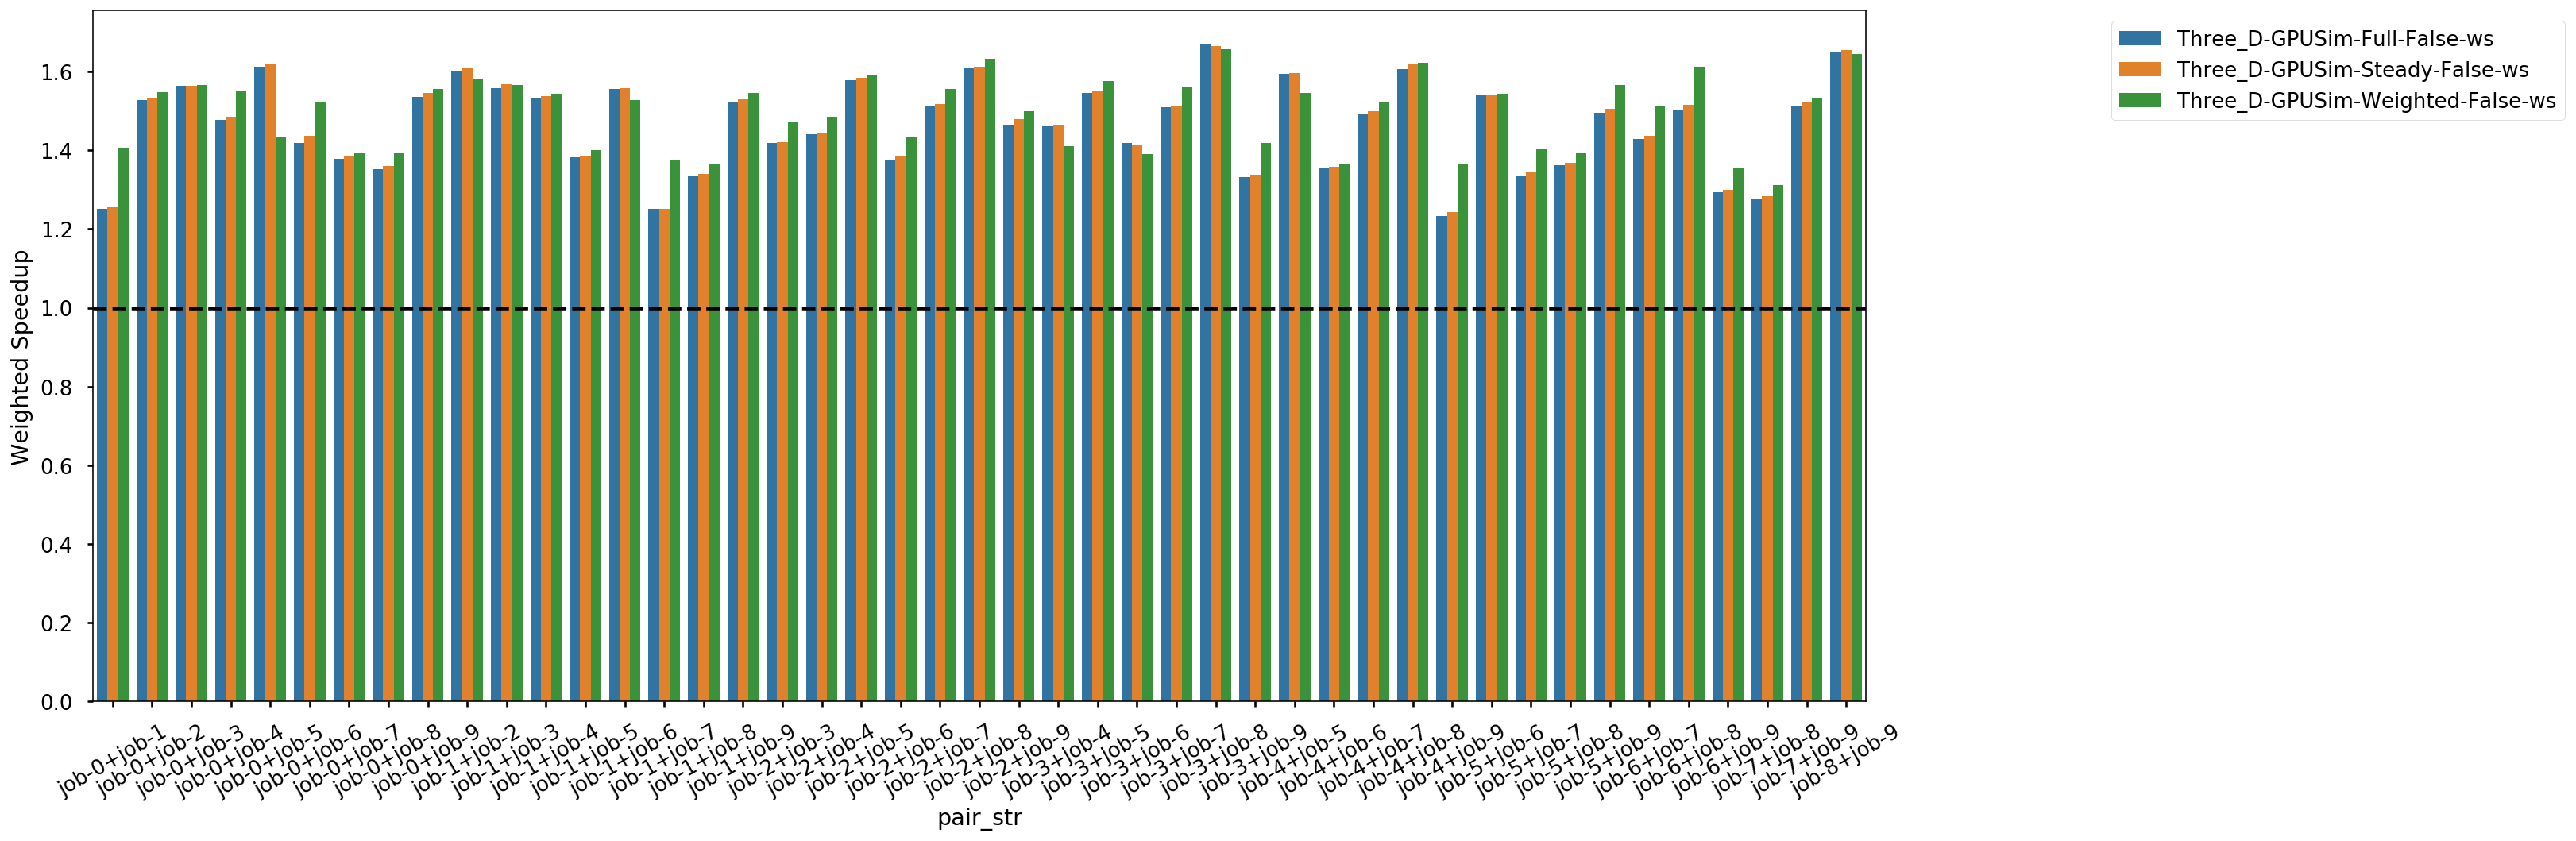

In [43]:

print("geomean 3d full:", scipy.stats.mstats.gmean(batch.df_pair[name_3d + '-ws']))
print("geomean 3d steady:", scipy.stats.mstats.gmean(batch.df_pair[name_3d_steady + '-ws']))
print("geomean 3d weighted:", scipy.stats.mstats.gmean(batch.df_pair[name_3d_weighted + '-ws']))

steady_error = np.abs(batch.df_pair[name_3d_steady + '-ws'] - batch.df_pair[name_3d + '-ws']) / batch.df_pair[name_3d + '-ws']
print("Error of 3d steady:", np.average(steady_error))

weighted_error = np.abs(batch.df_pair[name_3d_weighted + '-ws'] - batch.df_pair[name_3d + '-ws']) / batch.df_pair[name_3d + '-ws']
print("Error of 3d weighted:", np.average(weighted_error))

cols = [name_3d + '-ws', 
        name_3d_steady + '-ws', 
        name_3d_weighted + '-ws',
       ]
df_steady_full_long = pd.melt(batch.df_pair, id_vars=['pair_str'], 
                          value_vars=cols, 
                          var_name='Stage Two').sort_values(['pair_str']).reset_index(drop=True)


plt.figure(figsize=(20,8))
ax = sns.barplot(x='pair_str', y='value', hue='Stage Two', data=df_steady_full_long, hue_order=cols)
plt.xticks(rotation=30)
plt.ylabel('Weighted Speedup')
# plt.ylim([0, 2])

ax.legend(bbox_to_anchor=(1.4, 1))
ax.axhline(1.0, ls='--', color="black")
plt.title('')

plt.show()

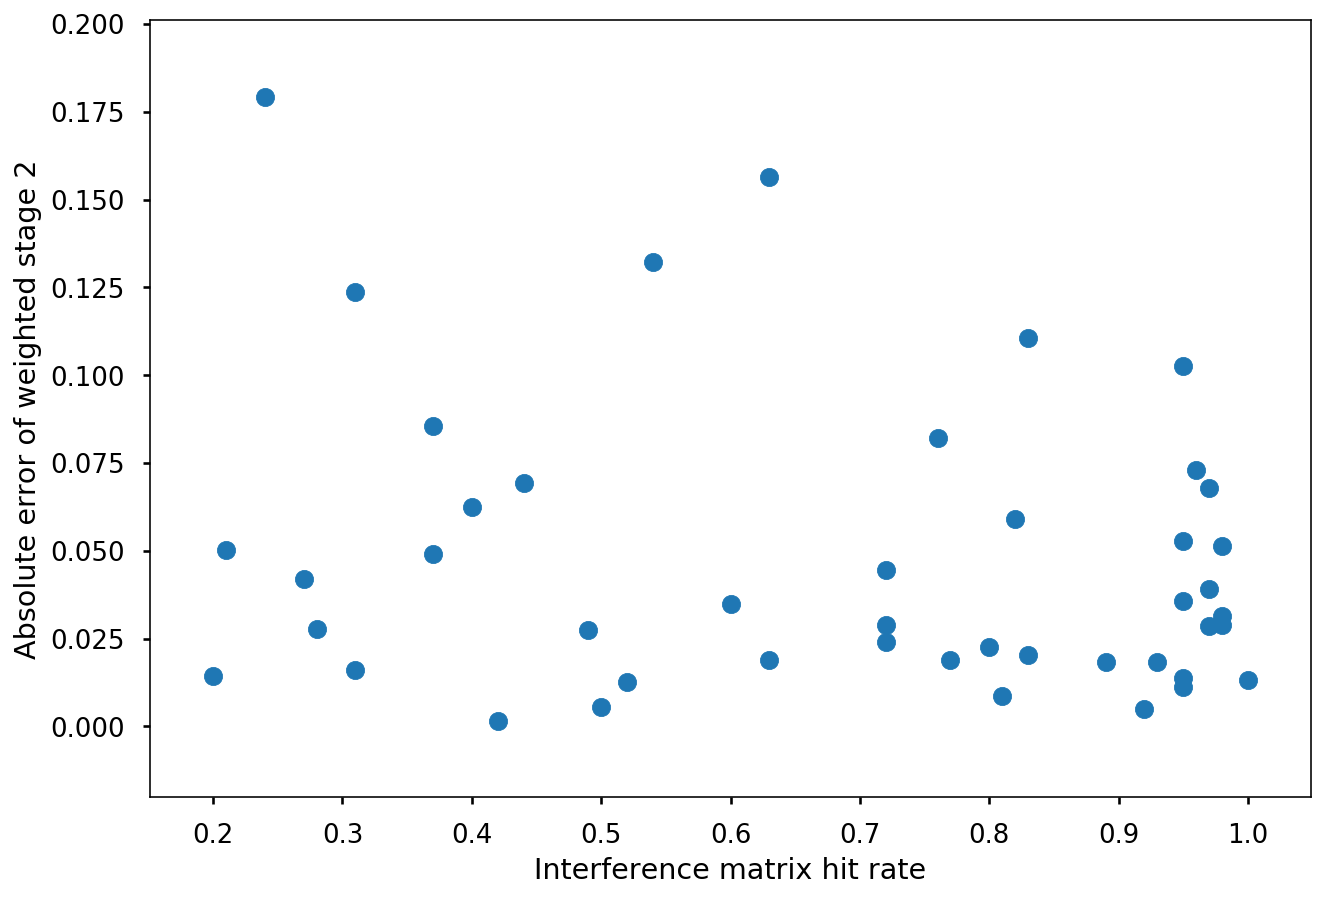

In [18]:
plt.scatter(hit_rate, weighted_error)
plt.xlabel("Interference matrix hit rate")
plt.ylabel("Absolute error of weighted stage 2")
plt.show()

In [42]:
def steady_iter_ratio(perf_obj):
    result = []
    for steady_iter, job in zip(perf_obj.steady_iter, perf_obj.jobs):
        result.append(steady_iter / job.num_iters)
    return result
        
steady_iter = np.concatenate(batch.df_pair['Three_D-GPUSim-Steady-False-perf'].apply(lambda x: steady_iter_ratio(x)), axis=0)
print(steady_iter)

[0.4     1.      0.4     0.025   0.4     0.025   0.6     0.025   0.4
 0.025   0.6     0.15    0.4     0.2     0.4     0.2     0.3     0.4
 0.8     0.0375  0.8     0.025   0.8     0.025   0.8     0.025   0.8
 0.1     0.8     0.2     0.8     0.2     0.78    0.4     0.025   0.025
 0.025   0.025   0.025   0.025   0.025   0.1     0.025   0.2     0.025
 0.2     0.025   0.4     0.025   0.025   0.025   0.025   0.025   0.1
 0.025   0.2     0.025   0.2     0.025   0.4     0.025   0.025   0.025
 0.1     0.025   0.2     0.0375  0.2     0.025   0.4     0.025   0.1
 0.025   0.3     0.025   0.2     0.02125 0.4     0.1     0.2     0.15
 0.2     0.125   0.8     0.2     0.2     0.19    0.4     0.2     0.4    ]


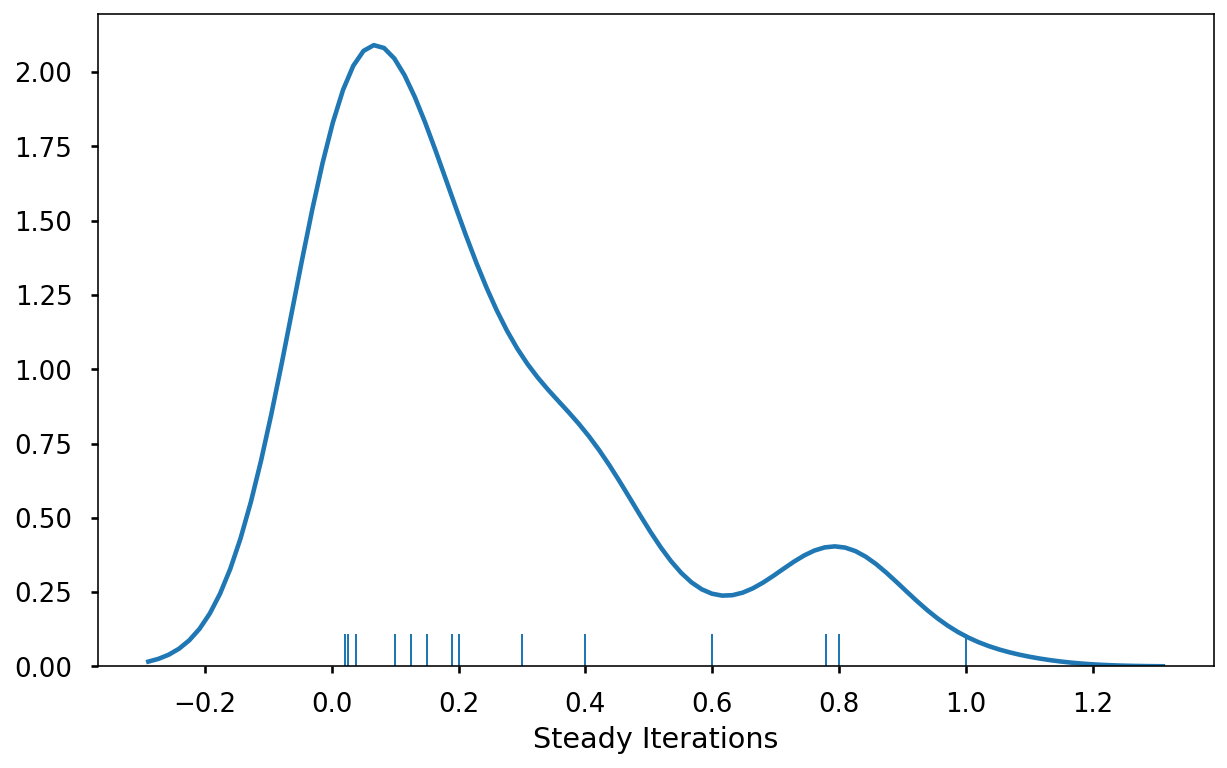

In [40]:
plt.figure(figsize=(10, 6))
sns.distplot(steady_iter, hist=False, rug=True, norm_hist=False, kde=True);
plt.xlabel("Steady Iterations")
# plt.title('ctx usage distribution')
plt.show()

# Debugging

In [1]:
from gpupool.predict import RunOption

In [2]:
RunOption.train_boosting_tree()
RunOption.kernel_wise_prediction()

X invalid? True
y invalid? False
X invalid? True
y invalid? False
(4630, 14) (4630,)
K-fold l1 error: 0.020437366515278194
K-fold l1 error: 0.020368068692182092
K-fold l1 error: 0.021886297842573784
K-fold l1 error: 0.02174430778508625
K-fold l1 error: 0.020983529549963947
Average abs relative error in test set: 3.01%.
X invalid? True
y invalid? False
X invalid? True
y invalid? False
(4630, 14) (4630,)
delta 0.7381989964929616


TypeError: kernel_wise_prediction() missing 1 required positional argument: 'self'